# ML: Evaluation of performance and interpretation (SHAP)

In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import lightgbm as lgb

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from glob import glob
import os
import optuna
import joblib
import json
import pickle
from tqdm import tqdm

## Load best parameters

In [2]:
agg = 'mean'
lookback_window = 60
run_date = '2022-06-02'
thresh = 12

source_dir = f'../experiments/window-{lookback_window}-filter-{thresh}/{agg}/'
study_name = f'{agg}-window-{lookback_window}-{run_date}'
storage_path = f'sqlite:///{source_dir}/{study_name}.db'

study = optuna.load_study(study_name=study_name, storage=storage_path)
res = study.trials_dataframe(attrs=('number', 'value', 'params', 'state', 'duration'))

In [3]:
# get current best params
best_params = {}
for key, value in res.sort_values('value', ascending=True).iloc[0].to_dict().items():
    if key.startswith('params_'):
        best_params[key.replace('params_', '')] = value
    elif key == 'value':
        print("Best (RMSE) Score: ", value)
        
fixed_params = {
    'tree_learner': 'data',
    'seed':11,
    'verbose': -1,
}

lgb_params = {}
lgb_params.update(fixed_params)
lgb_params.update(best_params)

if lgb_params['boosting_type'] == 'dart':
    del lgb_params['top_rate'], lgb_params['other_rate']
else:    
    top_rate = lgb_params['top_rate']
    other_rate = lgb_params['other_rate']
    
    # corrects the top_rate/other_rate values to only sum to 1
    if (top_rate + other_rate) > 1.0:
        lgb_params['other_rate'] = other_rate / (top_rate + other_rate)
        lgb_params['top_rate'] = top_rate / (top_rate + other_rate)
lgb_params

Best (RMSE) Score:  6.109755145856355


{'tree_learner': 'data',
 'seed': 11,
 'verbose': -1,
 'boosting_type': 'goss',
 'learning_rate': 0.04517448957087013,
 'max_bin': 111,
 'min_data_in_leaf': 147,
 'num_iterations': 623,
 'num_leaves': 408,
 'objective': 'regression',
 'other_rate': 0.14647135743253362,
 'top_rate': 0.80372847012092}

## Load data and filter

In [4]:
featname_map = {
    'dayofweek': 'Day',
    'hour': 'Hour',
    'number_of_lanes': 'Number of Lanes',
    'speed_limit_kph': 'Speed Limit',
    'pix_business_4x4' : 'Nearby Commercial',
    'pix_residential_4x4': 'Nearby Residential', 
    'pix_industrial_4x4' : 'Nearby Industrial',
    'pix_institutional_4x4' : 'Nearby Institutional',
    'elevation' : 'Elevation',
}

In [5]:
data_dir = f'../datasets/inference/window-{lookback_window}-filter-{thresh}'

# load data
test = pd.read_csv(f'{data_dir}/{agg}-window-{lookback_window}-test-{run_date}.csv')
retrain = pd.read_csv(f'{data_dir}/{agg}-window-{lookback_window}-retrain-{run_date}.csv')

In [6]:
print("Retrain shape: ", retrain.shape)
print("Test shape: ", test.shape)

Retrain shape:  (1067001, 43)
Test shape:  (266751, 43)


In [7]:
# usecols for ML
discrete_num_cols = ['number_of_lanes', 'speed_limit_kph',]
building_types = ['residential', 'business', 'industrial', 'institutional']
pixel_size = '4x4'
landuse_cols = [f'pix_{type_}_{pixel_size}' for type_ in building_types]
num_cols = landuse_cols + discrete_num_cols + ['elevation']

# cat cols
cat_cols = ['hour', 'dayofweek']
features = sorted(cat_cols + num_cols) # sort for reference in feature order
cat_cols_index = [index for (index, col) in enumerate(features) if col in cat_cols]
print("Catagorical columns index: ", cat_cols_index)

Catagorical columns index:  [0, 2]


In [8]:
results_dir = f"../results/window-{lookback_window}-filter-{thresh}"
column_labels_dir = "column-labels"
save_dir = os.path.join(results_dir, column_labels_dir)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# write feature order to file as reference
with open(f'{save_dir}/{study_name}-columnrefs.pickle', 'wb') as f:
    pickle.dump(features, f)

In [9]:
# use recomputed_speed
X_train, y_train = retrain[features], retrain['agg_speed']
X_test, y_test = test[features], test['agg_speed']

In [ ]:
%%time
model = lgb.LGBMRegressor(**lgb_params)
model.fit(X_train, y_train, categorical_feature=cat_cols_index)

Found `num_iterations` in params. Will use it instead of argument
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=147, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=147


In [ ]:
# save model
save_dir = os.path.join(results_dir, 'models')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
model.booster_.save_model(f'{save_dir}/{study_name}-model.txt')

In [ ]:
# save y-yhat
y_pred = model.predict(X_test)
y_true = y_test.values

y_yhat = {
    'true': list(y_true),
    'pred' : list(y_pred)
}

save_dir = os.path.join(results_dir, 'predictions')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
with open(f'{save_dir}/{study_name}-preds.json', 'w') as f:
    json.dump(y_yhat, f)

In [ ]:
def get_score(y_true, y_preds):
    return r2_score(y_true, y_preds)
def rmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

print("R2: ", get_score(y_true, y_pred))
print("RMSE: ", rmse(y_true, y_pred))
print("MAE: ", mean_absolute_error(y_true, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_true, y_pred))
# MAPE spikes because of y_true having values of zero, because of the division by epsilon

In [ ]:
def plot_lgb_yyhat(y_true, y_pred, title, ax):
    temp = pd.DataFrame()
    temp['True Value'] = y_true
    temp['Predicted Value'] = y_pred
    temp.plot(kind='scatter', x='True Value', y='Predicted Value',
              ax=ax, alpha=0.1, c='green', marker='*')
    
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('True Value', fontsize=12)
    ax.set_ylabel('Predicted Value', fontsize=12)

    ax.set_ylim([i for i in ax.get_xlim()])
    
    # diagonal perfect prediction reference
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, c='black',
                   label='Perfect Prediction')
    ax.legend(fontsize=15, loc='upper left')
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # set spines lw
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    
    # tick params
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    
    r2 = get_score(y_true, y_pred)
    ax.annotate(f"R2={r2:.2f}", size=15, xy=(55, 0))
    
    rmse_score = rmse(y_true, y_pred)
    ax.annotate(f"RMSE={rmse_score:.2f}", size=15, xy=(55, 5))
    return ax

In [ ]:
figures_dir = f'../figures/window-{lookback_window}-filter-{thresh}'
save_dir = os.path.join(figures_dir, 'performance')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
fig, ax = plt.subplots(figsize=(8, 8))
plot_lgb_yyhat(y_true, y_pred, title=None, ax=ax)
    
fig.savefig(f'{save_dir}/{study_name}-yyhat.jpg', dpi=600, bbox_inches='tight')
plt.show()

## Baseline Comparison

The naive baseline considers the points in the training set and aggregates the `agg_speed` according to groups based on `dayofweek`, `hour`, and `road_osmid`. The following are some considerations in this approach:

1. some combinations of `dayofweek`, `hour` and `road_osmid` that are in test are not in train.
2. Due to #1, we remove some points in test and consequently remove the same in the test set for the model-predicted speeds.
3. The performance metric reported in the comparison with baseline has reduced data points due to #2.

In [ ]:
baseline_table = retrain.groupby(['dayofweek', 'hour', 'road_osmid']).agg({'agg_speed':np.mean})

# transform to dict for faster look up
baseline_table = baseline_table.to_dict()

In [ ]:
def get_baseline_predict(key):
    """Return a naive prediction using historical average speed on road at 
    a particular dayofweek and hour"""
    # dictionary look up
    return baseline_table['agg_speed'].get(key, np.nan)

In [ ]:
# tqdm.pandas()
# y_pred_baseline = test.progress_apply(
#     lambda row: get_baseline_predict(
#         baseline_table, row.dayofweek, row.hour, row.road_osmid
#     ), axis=1
# )

tqdm.pandas()
y_pred_baseline = test.progress_apply(
    lambda row: get_baseline_predict(
        (row.dayofweek, row.hour, row.road_osmid)
    ), axis=1
)

In [ ]:
nan_mask = y_pred_baseline.isna().values
y_pred_baseline_filtered = y_pred_baseline.values[~nan_mask] # baseline
y_pred_filtered = y_pred[~nan_mask] # model
y_true_filtered = y_true[~nan_mask] # actual/true

print("Number of nans: ", nan_mask.sum())
print(y_pred_baseline_filtered.shape)
print(y_pred_filtered.shape)
print(y_true_filtered.shape)

In [24]:
print("model R2: ", get_score(y_true_filtered, y_pred_filtered))
print("model RMSE: ", rmse(y_true_filtered, y_pred_filtered))
print("model MAE: ", mean_absolute_error(y_true_filtered, y_pred_filtered))
print("model MAPE: ", mean_absolute_percentage_error(y_true_filtered, y_pred_filtered))

print("\n\n")

print("baseline R2: ", get_score(y_true_filtered, y_pred_baseline_filtered))
print("baseline RMSE: ", rmse(y_true_filtered, y_pred_baseline_filtered))
print("baseline MAE: ", mean_absolute_error(y_true_filtered, y_pred_baseline_filtered))
print("baseline MAPE: ", mean_absolute_percentage_error(y_true_filtered, y_pred_baseline_filtered))

model R2:  0.7563044087952431
model RMSE:  5.717854285595652
model MAE:  4.321518859110918
model MAPE:  104366319798213.73



baseline R2:  0.7383715694403645
baseline RMSE:  5.924500158433624
baseline MAE:  4.386986676026209
baseline MAPE:  140595175470728.58


In [25]:
# save y-yhat

y_yhat_baseline = {
    'true': list(y_true_filtered),
    'pred' : list(y_pred_baseline_filtered)
}

save_dir = os.path.join(results_dir, 'predictions')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
with open(f'{save_dir}/{study_name}-preds-baseline.json', 'w') as f:
    json.dump(y_yhat_baseline, f)

### Mann-whiteney U test

In [26]:
# insert mann-whiteny U test here

In [36]:
## squared-diff
# baseline_err = (y_true_filtered - y_pred_baseline_filtered) ** 2
# model_err = (y_true_filtered - y_pred_filtered) ** 2

# diff
baseline_err = (y_true_filtered - y_pred_baseline_filtered)
model_err = (y_true_filtered - y_pred_filtered)

# # absolute diff
# baseline_err = np.abs(y_true_filtered - y_pred_baseline_filtered)
# model_err = np.abs(y_true_filtered - y_pred_filtered)

In [37]:
# mwu test
from scipy.stats import mannwhitneyu

U, p_val = mannwhitneyu(
    model_err, baseline_err, 
    use_continuity=False,
    alternative='two-sided', 
    method='asymptotic'
)

print("Test statistic, U: ", U)
print("p-value: ", p_val)

Test statistic, U:  35060772014.0
p-value:  0.026396731476160576


In [43]:
from scipy.stats import ttest_ind

t, p_val = ttest_ind(
    model_err, baseline_err,
    equal_var=False,
)

print("Test statistic, t: ", t)
print("p-value: ", p_val)

Test statistic, t:  -0.5080632086162502
p-value:  0.6114092273857099


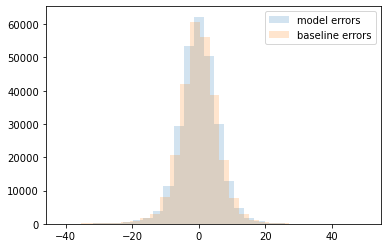

In [40]:
# plot distribution of baseline_err and model_err on top of each other

# bins = numpy.linspace(-10, 10, 100)
plt.hist(model_err, bins=30, alpha=0.2, label='model errors')
plt.hist(baseline_err, bins=30, alpha=0.2, label='baseline errors')
plt.legend(loc='upper right')
plt.show()

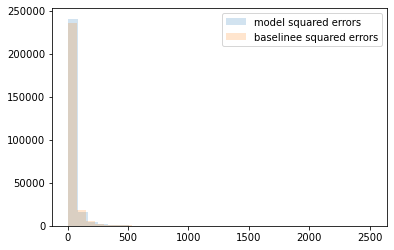

In [42]:
plt.hist(model_err**2, bins=30, alpha=0.2, label='model squared errors')
plt.hist(baseline_err**2, bins=30, alpha=0.2, label='baselinee squared errors')
plt.legend(loc='upper right')
plt.show()

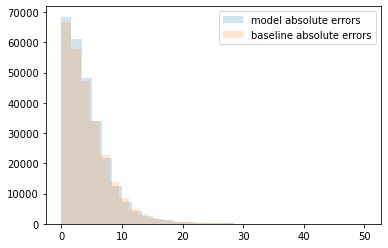

In [41]:
plt.hist(np.abs(model_err), bins=30, alpha=0.2, label='model absolute errors')
plt.hist(np.abs(baseline_err), bins=30, alpha=0.2, label='baseline absolute errors')
plt.legend(loc='upper right')
plt.show()

## SHAP Evaluation

In [ ]:
X_test = X_test.rename(columns=featname_map)

In [ ]:
%%time
print("Test set shape: ", X_test.shape)

# perfrom shap on test set
explainer = shap.TreeExplainer(model)

In [ ]:
%%time
explanation = explainer(X_test)

In [ ]:
%%time
# shap_values = explainer.shap_valus(X_test.sample(n=1000, replace=False)) # change to X_test
shap_values = explainer.shap_values(X_test) 

In [ ]:
save_dir = os.path.join(results_dir, 'shap-vals')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

with open(f'{save_dir}/{study_name}-shap-vals.pickle', 'wb') as f:
    pickle.dump(shap_values, f)

### Global Interpretations

In [ ]:
%%time
# plots beeswarm
sum_fig = shap.summary_plot(shap_values, X_test, show=False)

# plt.title('Summary Plot of SHAP Importance', fontsize=18)
plt.ylabel('Features', fontsize=14)

## in case column names are not good for plotting use a name mapper
# ax = plt.gca()
# new_labels = [featname_map[i.get_text()] for i in ax.get_yticklabels()]
# ax.set_yticklabels(new_labels)

plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

figures_dir = f'../figures/window-{lookback_window}-filter-{thresh}'
save_dir = os.path.join(figures_dir, 'shap')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

plt.savefig(f'{save_dir}/{study_name}-beeswarm.jpg', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
fi_fig = shap.plots.bar(explanation, max_display=X_test.shape[1], show=False)
# plt.title('Average SHAP Importance', fontsize=12)
# plt.ylabel('Features', fontsize=14)


## in case column names are not good for plotting use a name mapper
# ax = plt.gca()
# new_labels = [featname_map[i.get_text()] for i in ax.get_yticklabels()]
# ax.set_yticklabels(new_labels)

## black bars
# for bar in ax.containers:
#     # plt.setp sets a property on all elements of the container
#     plt.setp(bar, color="black")



# Hide the right and top spines
ax.spines['left'].set_visible(False)

plt.savefig(f'{save_dir}/{study_name}-fi.jpg', dpi=600, bbox_inches='tight')
plt.show()

### Local Interpretations

#### Waterfall and forceplots plots

In [ ]:
# get a low error prediction for a predicted vehicle moving average speed
speed = 0 # speed of interest
speed_indexes = np.where(y_true==speed)[0]
speed_errors = (np.abs(y_true - y_pred))[y_true==speed]
sorted_indexed_errors = sorted(list(zip(speed_indexes, speed_errors)), key=lambda x:x[1])

# index of best predicted zero speed
print("Absolute Error: ", sorted_indexed_errors[0][1])
index = sorted_indexed_errors[0][0]

In [ ]:
# bar plots are used since waterfall source code has some bugs: pl.ioff() plt not found
# wf_fig = shap.waterfall_plot(explanation[index], show=False)
wf_fig = shap.waterfall_plot(explanation[index])

plt.savefig(f'{save_dir}/{study_name}-waterfall-speed-{speed}.jpg', 
            dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
bar_fig = shap.plots.bar(explanation[index], show=False)

plt.savefig(f'{save_dir}/{study_name}-localbar-speed-{speed}.jpg', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
def force_plot(explainer, shap_values, X_test, j, speed):
    shap.initjs() 
    p = shap.force_plot(
        explainer.expected_value, 
        shap_values[j], X_test.iloc[[j]], 
        show=True,
    )
    plt.savefig(f'{save_dir}/{study_name}-force-speed-{speed}.jpg', dpi=600, bbox_inches='tight')
    plt.close()
    return(p)

In [ ]:
force_plot(explainer, shap_values, X_test, j=index, speed=speed)

In [ ]:
# get a low error prediction for a predicted vehicle moving average speed
speed = 10 # speed of interest
speed_indexes = np.where(y_true==speed)[0]
speed_errors = (np.abs(y_true - y_pred))[y_true==speed]
sorted_indexed_errors = sorted(list(zip(speed_indexes, speed_errors)), key=lambda x:x[1])

# index of best predicted zero speed
print("Absolute Error: ", sorted_indexed_errors[0][1])
index = sorted_indexed_errors[0][0]

In [ ]:
# bar plots are used since waterfall source code has some bugs: pl.ioff() plt not found
# wf_fig = shap.waterfall_plot(explanation[index], show=False)
wf_fig = shap.waterfall_plot(explanation[index])

plt.savefig(f'{save_dir}/{study_name}-waterfall-speed-{speed}.jpg', 
            dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
bar_fig = shap.plots.bar(explanation[index], show=False)

plt.savefig(f'{save_dir}/{study_name}-localbar-speed-{speed}.jpg', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
force_plot(explainer, shap_values, X_test, j=index, speed=speed)

In [ ]:
# get a low error prediction for a predicted vehicle moving average speed
speed = 20 # speed of interest
speed_indexes = np.where(y_true==speed)[0]
speed_errors = (np.abs(y_true - y_pred))[y_true==speed]
sorted_indexed_errors = sorted(list(zip(speed_indexes, speed_errors)), key=lambda x:x[1])

# index of best predicted zero speed
print("Absolute Error: ", sorted_indexed_errors[0][1])
index = sorted_indexed_errors[0][0]

bar_fig = shap.plots.bar(explanation[index], show=False)

plt.savefig(f'{save_dir}/{study_name}-localbar-speed-{speed}.jpg', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# get a low error prediction for a predicted vehicle moving average speed
speed = 30 # speed of interest
speed_indexes = np.where(y_true==speed)[0]
speed_errors = (np.abs(y_true - y_pred))[y_true==speed]
sorted_indexed_errors = sorted(list(zip(speed_indexes, speed_errors)), key=lambda x:x[1])

# index of best predicted zero speed
print("Absolute Error: ", sorted_indexed_errors[0][1])
index = sorted_indexed_errors[0][0]

bar_fig = shap.plots.bar(explanation[index], show=False)

plt.savefig(f'{save_dir}/{study_name}-localbar-speed-{speed}.jpg', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# get a low error prediction for a predicted vehicle moving average speed
speed = 40 # speed of interest
speed_indexes = np.where(y_true==speed)[0]
speed_errors = (np.abs(y_true - y_pred))[y_true==speed]
sorted_indexed_errors = sorted(list(zip(speed_indexes, speed_errors)), key=lambda x:x[1])

# index of best predicted zero speed
print("Absolute Error: ", sorted_indexed_errors[0][1])
index = sorted_indexed_errors[0][0]

bar_fig = shap.plots.bar(explanation[index], show=False)

plt.savefig(f'{save_dir}/{study_name}-localbar-speed-{speed}.jpg', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# get a low error prediction for a predicted vehicle moving average speed
speed = 50 # speed of interest
speed_indexes = np.where(y_true==speed)[0]
speed_errors = (np.abs(y_true - y_pred))[y_true==speed]
sorted_indexed_errors = sorted(list(zip(speed_indexes, speed_errors)), key=lambda x:x[1])

# index of best predicted zero speed
print("Absolute Error: ", sorted_indexed_errors[0][1])
index = sorted_indexed_errors[0][0]

bar_fig = shap.plots.bar(explanation[index], show=False)

plt.savefig(f'{save_dir}/{study_name}-localbar-speed-{speed}.jpg', dpi=600, bbox_inches='tight')
plt.show()

# End